# PPO with CNN - Closing Price  

Getting some data:

In [510]:
import numpy as np
import yfinance as yf
import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import math
import random

In [512]:
tickers = ["AAPL","MSFT","GOOGL","META","AMZN", "TSLA", "NVDA"]

data = {}
for t in tickers:
    df = yf.download(t, start="2020-01-01", end="2023-01-01")
    closes = df["Close"].values.astype(np.float32)
    mu, sigma = closes.mean(), closes.std()
    data[t] = {
        "dates": df.index,
        "raw":    closes,
        "norm":  (closes - mu) / sigma
    }

raw_prices = { t: data[t]["raw"]  for t in tickers }
normalized_prices = { t: data[t]["norm"] for t in tickers }

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### plotting the downloaded data 

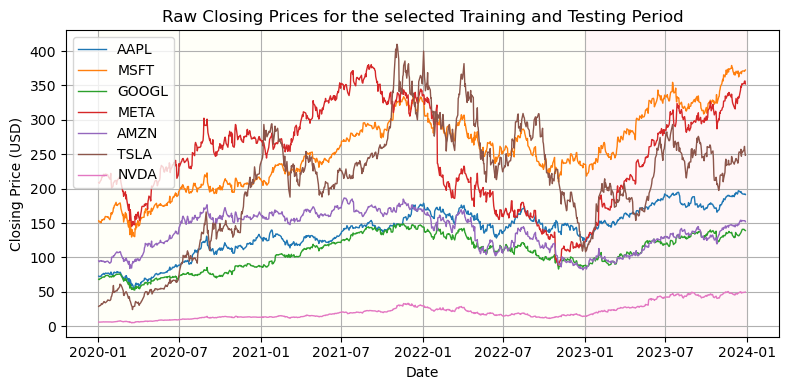

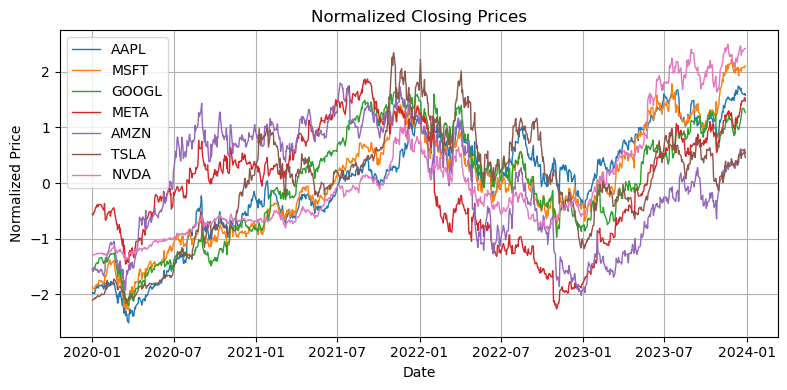

In [63]:
from datetime import datetime

plt.figure(figsize=(8, 4))
for t in tickers:
    plt.plot(data[t]["dates"], data[t]["raw"], label=t, linewidth=1)

# Shade 2020–2023 in light blue
plt.axvspan(datetime(2020, 1, 1), datetime(2023, 1, 1), color='lightyellow', alpha=0.2)

# Shade 2023–2024 in light green
plt.axvspan(datetime(2023, 1, 1), datetime(2024, 1, 1), color='lightpink', alpha=0.1)

plt.title("Raw Closing Prices for the selected Training and Testing Period")
plt.xlabel("Date")
plt.ylabel("Closing Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("raw_cp_7stocks_shaded.png")
plt.show()


plt.figure(figsize=(8,4))
for t in tickers:
    plt.plot(data[t]["dates"], data[t]["norm"], label=t, linewidth = 1)
plt.title("Normalized Closing Prices")
plt.xlabel("Date")
plt.ylabel("Normalized Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("normalized_cp_7stocks.png")
plt.show()

### PPO for multiple stocks

In [ ]:
state_dim   = 5 # window size 
action_dim  = 1   # how many features we have 
hidden_dim  = 64 # hidden layer size 
lr          = 3e-4
feat_dim = 1
gamma       = 0.9
lam         = 0.95
clip_eps    = 0.2
epochs      = 700
batch_size  = 64
l2_lambda   = 1e-4

state_window = state_dim
states, next_states, rewards, dones = [], [], [], []

num_days = len(normalized_prices[tickers[0]]) - state_window - 1

for day in range(num_days):
    s_day, ns_day, r_day = [], [], []

    for t in tickers:
        arr = normalized_prices[t]                               # 1-D array of closes
        s_feat  = arr[day           : day+state_window]          # (5,)
        ns_feat = arr[day+1         : day+1+state_window]        # (5,)
        reward  = arr[day+state_window+1] - arr[day+state_window]

        s_day .append(s_feat)
        ns_day.append(ns_feat)
        r_day .append(reward.item())

    states     .append(s_day)
    next_states.append(ns_day)
    rewards    .append(r_day)
    dones      .append([0.0] * len(tickers))

# to tensors ─ note final shape: [days, stocks, 5]
states      = torch.tensor(np.array(states),      dtype=torch.float32)
next_states = torch.tensor(np.array(next_states), dtype=torch.float32)
rewards     = torch.tensor(np.array(rewards),     dtype=torch.float32)
dones       = torch.tensor(np.array(dones),       dtype=torch.float32)

class RiskyCNNPolicy(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=2),
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=2),
            nn.ReLU(),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=2),
            nn.ReLU(),
            nn.Flatten()
        )

        # Adjust flattened size
        conv_out_size = (state_dim - 3) * 128

        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 256),
            nn.ReLU(),
            nn.Dropout(0.1),                     # Encourage risk via exploration
            nn.Linear(256, action_dim)
        )

        self.value_head = nn.Linear(conv_out_size, 1)
        self.log_std = nn.Parameter(torch.zeros(action_dim))

    def forward(self, x):
        x = x.view(x.size(0), 1, -1)
        x_conv = self.conv(x)
        return self.fc(x_conv), self.value_head(x_conv)

# instantiate & optimiser
model = CNNPolicy()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=l2_lambda)

def get_action(state, model):
    mean, _ = model(state)
    std  = model.log_std.exp()
    dist = torch.distributions.Normal(mean, std)
    action   = dist.sample()
    log_prob = dist.log_prob(action).sum(axis=-1)
    return action, log_prob

# 5. Collect trajectories

actor_loss_hist = []
logprob_hist = []
model.eval()                  # ← freeze BatchNorm statistics
with torch.no_grad():
    all_actions, all_log_probs, all_values = [], [], []

    for day in range(len(states)):
        for stock in range(states.size(1)):
            s = states[day, stock].view(1, -1)   # (1, seq_len)
            a, lp = get_action(s, model)
            _, v  = model(s)

            all_actions.append(a)
            all_log_probs.append(lp)
            all_values.append(v)

    # bootstrap final values …
    for stock in range(next_states.size(1)):
        s_final = next_states[-1, stock].view(1, -1)
        all_values.append(model(s_final)[1])

model.train()                 # ← turn BatchNorm back on for PPO training

# to tensors
actions   = torch.cat(all_actions).view(len(states), -1, action_dim)
log_probs = torch.stack(all_log_probs).view(len(states), -1)
values    = torch.stack(all_values).view(len(states)+1, states.size(1))

advantages = torch.zeros_like(rewards)
for stock in range(states.size(1)):
    last_adv = 0
    for t in reversed(range(len(states))):
        delta    = rewards[t,stock] \
                   + gamma * values[t+1,stock] * (1 - dones[t,stock]) \
                   - values[t,stock]
        last_adv = delta + gamma * lam * (1 - dones[t,stock]) * last_adv
        advantages[t,stock] = last_adv
returns = advantages + values[:-1]

# flatten for PPO
flat_states = states.view(-1, state_dim * feat_dim)   # feat_dim = 1
flat_actions = actions.view(-1, action_dim)
flat_lp_old  = log_probs.view(-1)
flat_ret     = returns.view(-1)
flat_adv     = advantages.view(-1)

critic_loss_hist = []
reward_hist = []
entropy_hist = []

n_trans   = flat_states.size(0)
n_batches = math.ceil(n_trans / batch_size)

for epoch in range(epochs):
    perm = torch.randperm(n_trans)
    epoch_actor_loss  = 0.0
    epoch_critic_loss = 0.0
    epoch_reward      = 0.0
    epoch_entropy     = 0.0
    epoch_logprob     = 0.0
    for batch_idx, start in enumerate(range(0, n_trans, batch_size), start=1):
        idx          = perm[start:start+batch_size]
        state_batch  = flat_states[idx]
        action_batch = flat_actions[idx].unsqueeze(1)
        old_logps_b  = flat_lp_old[idx].detach()
        return_batch = flat_ret[idx].detach()
        adv_batch    = flat_adv[idx].detach()

        # actor
        mean, _ = model(state_batch)
        std      = model.log_std.exp()
        dist     = torch.distributions.Normal(mean, std)
        new_lps  = dist.log_prob(action_batch).sum(axis=-1)

        ratio      = (new_lps - old_logps_b).exp()
        clipped    = torch.clamp(ratio, 1 - clip_eps, 1 + clip_eps) * adv_batch
        actor_loss = -torch.min(ratio * adv_batch, clipped).mean()

        # critic
        _, value_pred = model(state_batch)
        value_pred = value_pred.squeeze(-1)
        critic_loss = F.mse_loss(value_pred, return_batch)

        loss = actor_loss + 0.5 * critic_loss

        batch_logprob = new_lps.mean()
        epoch_logprob += batch_logprob.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_actor_loss  += actor_loss.item()
        epoch_critic_loss += critic_loss.item()
        epoch_reward      += return_batch.mean().item()

        print(f"  Epoch {epoch+1}, Batch {batch_idx}/{n_batches} → Batch Loss: {loss.item():.4f}")

    actor_loss_hist .append(epoch_actor_loss  / n_batches)
    critic_loss_hist.append(epoch_critic_loss / n_batches)
    reward_hist     .append(epoch_reward      / n_batches)
    entropy_hist    .append(epoch_entropy     / n_batches)
    logprob_hist    .append(epoch_logprob     / n_batches)

    print(f"*** Finished Epoch {epoch+1}/{epochs}: last batch loss {loss.item():.4f} ***")

  Epoch 1, Batch 1/83 → Batch Loss: 0.0910
  Epoch 1, Batch 2/83 → Batch Loss: 0.1156
  Epoch 1, Batch 3/83 → Batch Loss: 0.1335
  Epoch 1, Batch 4/83 → Batch Loss: 0.0416
  Epoch 1, Batch 5/83 → Batch Loss: 0.0486
  Epoch 1, Batch 6/83 → Batch Loss: 0.0639
  Epoch 1, Batch 7/83 → Batch Loss: 0.0717
  Epoch 1, Batch 8/83 → Batch Loss: 0.3879
  Epoch 1, Batch 9/83 → Batch Loss: 0.0151
  Epoch 1, Batch 10/83 → Batch Loss: 0.1111
  Epoch 1, Batch 11/83 → Batch Loss: 0.2125
  Epoch 1, Batch 12/83 → Batch Loss: -0.0453
  Epoch 1, Batch 13/83 → Batch Loss: 0.2170
  Epoch 1, Batch 14/83 → Batch Loss: 0.2733
  Epoch 1, Batch 15/83 → Batch Loss: 0.0852
  Epoch 1, Batch 16/83 → Batch Loss: 0.2341
  Epoch 1, Batch 17/83 → Batch Loss: 0.2526
  Epoch 1, Batch 18/83 → Batch Loss: 0.0723
  Epoch 1, Batch 19/83 → Batch Loss: 0.1789
  Epoch 1, Batch 20/83 → Batch Loss: 0.1424
  Epoch 1, Batch 21/83 → Batch Loss: 0.0794
  Epoch 1, Batch 22/83 → Batch Loss: 0.2275
  Epoch 1, Batch 23/83 → Batch Loss: 0.0

In [677]:
model.eval()
torch.save(model.state_dict(), "model_cnn_6.pth")


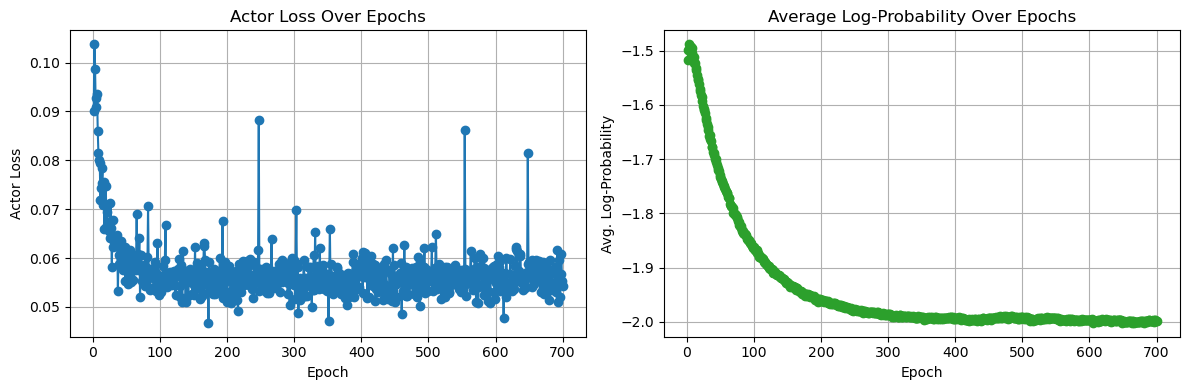

In [723]:
# Plot results after training
epochs_range = list(range(1, len(actor_loss_hist)+1))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

# 5.3.1 Actor Loss Over Epochs
ax1.plot(epochs_range, actor_loss_hist, marker='o')
ax1.set_title("Actor Loss Over Epochs")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Actor Loss")
ax1.grid(True)

# 5.3.3 Log-Probability of Actions
ax2.plot(epochs_range, logprob_hist, marker='o', color='tab:green')
ax2.set_title("Average Log-Probability Over Epochs")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Avg. Log-Probability")
ax2.grid(True)

plt.tight_layout()
plt.savefig("CNN_CP_actor_loss_and_logprob7.png", dpi=300)
plt.show()


### Trading Environment 

In [663]:
class MultiStockEnvironment:
    def __init__(self, raw_prices, window_size, initial_cash=10000):
        self.raw_prices   = raw_prices
        self.window_size  = window_size
        self.initial_cash = float(initial_cash)
        self.tickers      = list(raw_prices.keys())
        self.reset()

    def reset(self):
        self.t = 0
        self.cash = self.initial_cash
        self.holdings = {t: 0.0 for t in self.tickers}
        self.portfolio_values = [self.initial_cash]
        self.done = False

        return {
            t: self.raw_prices[t][0:self.window_size]
            for t in self.tickers
        }

    def step(self, actions):
        # Liquidate negatives
        freed_cash = 0.0
        for t in self.tickers:
            if actions[t] < 0 and self.holdings[t] > 0:
                price = self.raw_prices[t][self.t + self.window_size].item()
                freed_cash += self.holdings[t] * price
                self.holdings[t] = 0.0
        self.cash += freed_cash

        # Allocate positives
        pos_actions = {t: actions[t] for t in self.tickers if actions[t] > 0}
        total_pos   = sum(pos_actions.values())
        if total_pos > 0 and self.cash > 0:
            for t, a in pos_actions.items():
                weight = a / total_pos
                price = self.raw_prices[t][self.t + self.window_size].item()
                buy_amount = self.cash * weight
                self.holdings[t] += buy_amount / price
            self.cash = 0.0

        # Compute portfolio value
        pv = self.cash
        for t in self.tickers:
            price = self.raw_prices[t][self.t + self.window_size].item()
            pv += self.holdings[t] * price
        self.portfolio_values.append(pv)

        # Advance time
        self.t += 1
        if self.t + self.window_size >= len(next(iter(self.raw_prices.values()))):
            self.done = True

        # Next state
        next_states = None
        if not self.done:
            next_states = {
                t: self.raw_prices[t][self.t : self.t + self.window_size]
                for t in self.tickers
            }

        return next_states, pv, self.done, {}


### buy and hold

In [666]:
class BuyAndHoldEnvironment:
    def __init__(self, raw_prices, initial_cash=10000):
        self.raw_prices = raw_prices
        self.initial_cash = initial_cash
        self.portfolio_values = []

    def run(self, start_index=10):
        # stack into shape (T,5)
        prices = np.stack([self.raw_prices[t] for t in tickers], axis=1)
        # equal allocation
        alloc = self.initial_cash / len(tickers)
        init_p = prices[start_index]            # [5,]
        shares = alloc / init_p                 # [5,]
        # build PV curve
        for p in prices[start_index+1:]:
            self.portfolio_values.append((shares * p).sum())

### Simulate Agent with the trained MLP once 

In [669]:
model.eval()

mean_price = {t: raw_prices[t].mean() for t in tickers}
std_price  = {t: raw_prices[t].std()  for t in tickers}

env = MultiStockEnvironment(raw_prices, window_size=state_dim)
state_dict = env.reset()

day = 0
print("Starting multi-stock simulation...\n")

while not env.done:
    actions, trades = {}, {}

    for t in tickers:
        win    = state_dict[t]                              # raw window
        norm_p = (win - mean_price[t]) / std_price[t]       # z-score
        st     = torch.tensor(norm_p, dtype=torch.float32).view(1, -1)

        # ***** sample action with the CNN *****
        a_tensor, _ = get_action(st, model)                 # (1,1)
        a_val        = a_tensor.item()
        actions[t]   = a_val

        # decide trade verb for logging
        if   a_val > 0 and env.holdings[t] == 0:
            trades[t] = "BUY"
        elif a_val < 0 and env.holdings[t] > 0:
            trades[t] = "SELL"
        else:
            trades[t] = "HOLD"

    # step environment
    next_states, port_val, done, _ = env.step(actions)

    # log
    cash   = float(env.cash)
    prices = {t: float(raw_prices[t][day + state_dim]) for t in tickers}
    held   = {t: float(env.holdings[t])               for t in tickers}

    print(f"Day {day}: Cash = {cash:.2f}, Portfolio = {port_val:.2f}")
    for t in tickers:
        print(f"  {t:>6s} | Price = {prices[t]:6.2f} | "
              f"Action = {actions[t]:6.4f} | Trade = {trades[t]:>4s} | "
              f"Held = {held[t]:6.4f}")
    print("-" * 60)

    # advance
    state_dict = next_states
    day += 1

print(f"\nDone. Final portfolio value: {env.portfolio_values[-1]:.2f}")

Starting multi-stock simulation...

Day 0: Cash = 0.00, Portfolio = 10000.00
    AAPL | Price =  74.96 | Action = -2.9003 | Trade = HOLD | Held = 0.0000
    MSFT | Price = 154.73 | Action = 1.9052 | Trade =  BUY | Held = 7.4274
   GOOGL | Price =  70.65 | Action = -4.9527 | Trade = HOLD | Held = 0.0000
    META | Price = 217.28 | Action = 3.9059 | Trade =  BUY | Held = 10.8437
    AMZN | Price =  95.05 | Action = -8.2903 | Trade = HOLD | Held = 0.0000
    TSLA | Price =  32.09 | Action = 10.3346 | Trade =  BUY | Held = 194.2685
    NVDA | Price =   6.05 | Action = 0.4323 | Trade =  BUY | Held = 43.1026
------------------------------------------------------------
Day 1: Cash = 0.00, Portfolio = 9952.17
    AAPL | Price =  75.13 | Action = 8.6830 | Trade =  BUY | Held = 54.5148
    MSFT | Price = 154.01 | Action = 6.6193 | Trade = HOLD | Held = 27.7010
   GOOGL | Price =  71.11 | Action = 3.3710 | Trade =  BUY | Held = 22.3618
    META | Price = 217.04 | Action = -1.7873 | Trade = SELL |

/var/folders/1b/2dv3_3nx66s3980gg6hg5g1m0000gn/T/ipykernel_1522/2098985875.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prices = {t: float(raw_prices[t][day + state_dim]) for t in tickers}


Day 43: Cash = 0.00, Portfolio = 9314.53
    AAPL | Price =  60.24 | Action = -4.3915 | Trade = SELL | Held = 0.0000
    MSFT | Price = 133.11 | Action = 4.8871 | Trade = HOLD | Held = 36.0158
   GOOGL | Price =  55.31 | Action = 2.3448 | Trade = HOLD | Held = 31.4501
    META | Price = 153.75 | Action = -11.5082 | Trade = HOLD | Held = 0.0000
    AMZN | Price =  83.83 | Action = -6.9613 | Trade = HOLD | Held = 0.0000
    TSLA | Price =  37.37 | Action = 6.4147 | Trade = HOLD | Held = 74.4189
    NVDA | Price =   5.39 | Action = -23.1169 | Trade = SELL | Held = 0.0000
------------------------------------------------------------
Day 44: Cash = 0.00, Portfolio = 10087.72
    AAPL | Price =  67.46 | Action = 0.8460 | Trade =  BUY | Held = 0.0000
    MSFT | Price = 152.03 | Action = 4.9331 | Trade = HOLD | Held = 36.0158
   GOOGL | Price =  60.42 | Action = 3.7787 | Trade = HOLD | Held = 31.4501
    META | Price = 169.48 | Action = 0.2807 | Trade =  BUY | Held = 0.0000
    AMZN | Price =  

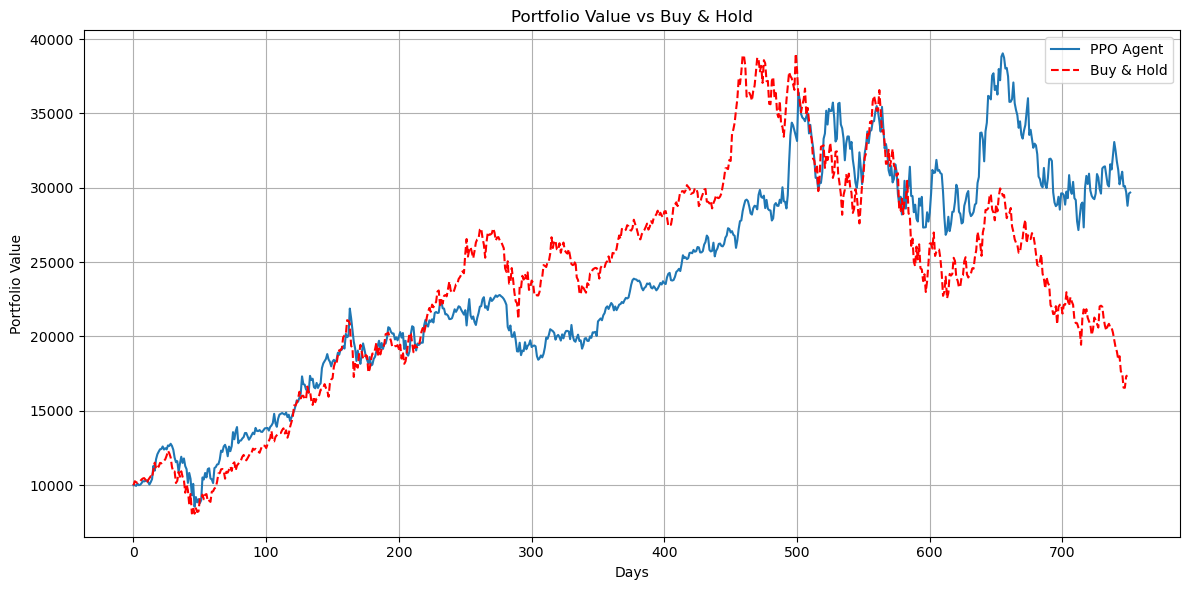


Final Results:
PPO final portfolio:       29677.06
Buy & Hold final portfolio:17379.21


In [671]:
bh_env = BuyAndHoldEnvironment(raw_prices)
bh_env.run(start_index=state_dim)

# 1) Plot PPO vs Buy & Hold
plt.figure(figsize=(12, 6))
plt.plot(env.portfolio_values, label='PPO Agent')
plt.plot(bh_env.portfolio_values, 'r--', label='Buy & Hold')
plt.title('Portfolio Value vs Buy & Hold')
plt.xlabel('Days')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3) Final values
print("\nFinal Results:")
print(f"PPO final portfolio:       {env.portfolio_values[-1]:.2f}")
print(f"Buy & Hold final portfolio:{bh_env.portfolio_values[-1]:.2f}")


### Run the Environment 50 times to get an average on how the MLP is performing

/var/folders/1b/2dv3_3nx66s3980gg6hg5g1m0000gn/T/ipykernel_1522/1794711075.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("CNN_Closing

Running PPO agent simulations...

Run  1/200 → Final Portfolio Value: 7407.26
Run  2/200 → Final Portfolio Value: 10698.67
Run  3/200 → Final Portfolio Value: 29984.41
Run  4/200 → Final Portfolio Value: 13881.89
Run  5/200 → Final Portfolio Value: 16566.65
Run  6/200 → Final Portfolio Value: 15585.30
Run  7/200 → Final Portfolio Value: 7275.15
Run  8/200 → Final Portfolio Value: 13236.23
Run  9/200 → Final Portfolio Value: 13304.71
Run 10/200 → Final Portfolio Value: 13968.84
Run 11/200 → Final Portfolio Value: 15653.05
Run 12/200 → Final Portfolio Value: 15194.17
Run 13/200 → Final Portfolio Value: 21821.27
Run 14/200 → Final Portfolio Value: 16861.53
Run 15/200 → Final Portfolio Value: 7700.84
Run 16/200 → Final Portfolio Value: 11877.13
Run 17/200 → Final Portfolio Value: 9239.90
Run 18/200 → Final Portfolio Value: 12189.65
Run 19/200 → Final Portfolio Value: 18947.25
Run 20/200 → Final Portfolio Value: 13095.31
Run 21/200 → Final Portfolio Value: 16380.09
Run 22/200 → Final Portfo

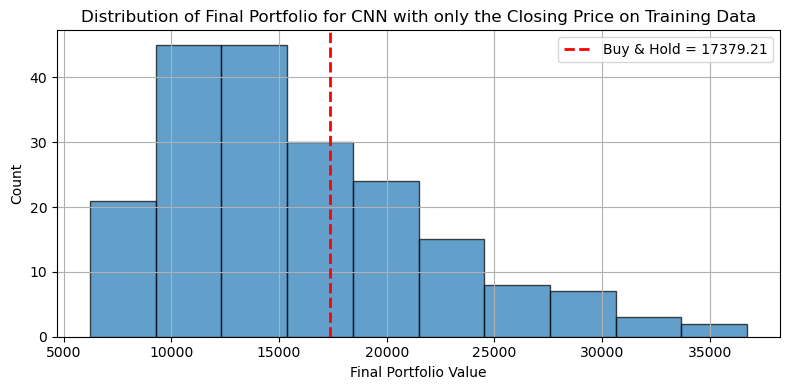

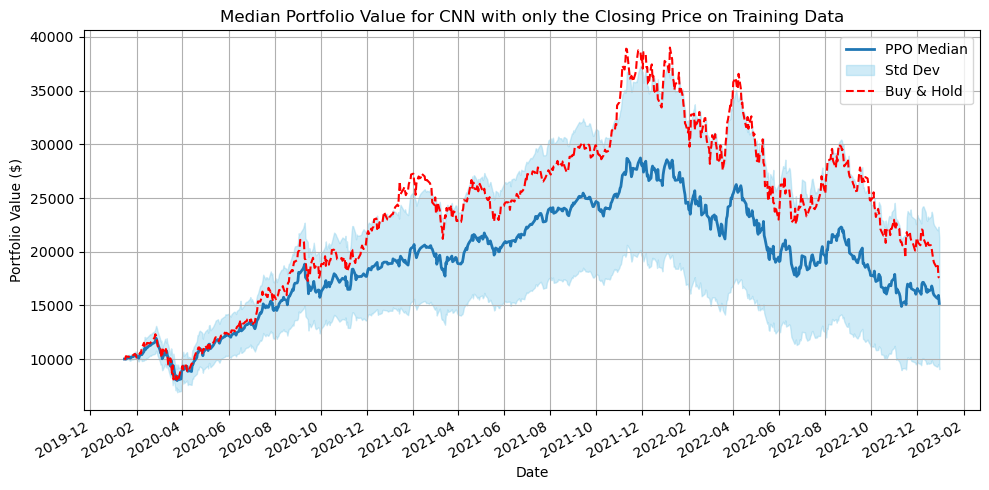

✓ Saved final portfolio values → CNN_Closing/cnn_final_portfolios.csv
✓ Saved all portfolio trajectories → CNN_Closing/cnn_all_trajectories.csv


In [612]:
import torch
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import torch.nn.functional as F

n_runs      = 200

tickers = ["AAPL", "MSFT", "GOOGL", "META", "AMZN", "TSLA", "NVDA"]

# === Load Buy & Hold ===
with open("buyhold_2020_2023.pkl", "rb") as f:
    bh_data = pickle.load(f)

bh_dates = pd.to_datetime(bh_data["dates"])
bh_curve = bh_data["curve"]
buy_hold_value = bh_curve[-1]
initial_cash = bh_curve[0]

# === Instantiate and load model ===
model = RiskyCNNPolicy(state_dim=state_dim, action_dim=action_dim)
model.load_state_dict(torch.load("CNN_Closing/model_cnn_5.pth"))
model.eval()

# === Normalize prices ===
mean_price = {t: raw_prices[t].mean() for t in tickers}
std_price  = {t: raw_prices[t].std()  for t in tickers}

# === Monte Carlo PPO Evaluation ===
final_portfolios = []

print("Running PPO agent simulations...\n")

for run in range(n_runs):
    env = MultiStockEnvironment(raw_prices, window_size=state_dim)
    state_dict = env.reset()
    done = False

    with torch.no_grad():
        while not done:
            actions = {}
            for t in tickers:
                win = state_dict[t]
                norm_p = (win - mean_price[t]) / std_price[t]
                st = torch.tensor(norm_p, dtype=torch.float32).view(1, -1)
                a_val = get_action(st, model)[0].item()
                actions[t] = a_val

            state_dict, pv, done, _ = env.step(actions)

    final_value = env.portfolio_values[-1]
    final_portfolios.append(final_value)
    ppo_trajectories.append(env.portfolio_values)  
    print(f"Run {run+1:2d}/{n_runs} → Final Portfolio Value: {final_value:.2f}")


# === Summary Stats ===
mean_pf = np.mean(final_portfolios)
std_pf  = np.std(final_portfolios)
min_pf  = np.min(final_portfolios)
max_pf  = np.max(final_portfolios)

print(f"\nOver {n_runs} runs → mean final portfolio = {mean_pf:.2f} ± {std_pf:.2f}")
print(f"min = {min_pf:.2f}, max = {max_pf:.2f}")
print(f"Buy & Hold final portfolio = {buy_hold_value:.2f}")

beats_bh = sum(fp > buy_hold_value for fp in final_portfolios)
loses_bh = n_runs - beats_bh
beat_pct = beats_bh / n_runs * 100
print(f"\nAgent beat Buy & Hold  : {beats_bh}/{n_runs} runs ({beat_pct:.1f}%)")
print(f"Agent lost to Buy&Hold : {loses_bh}/{n_runs} runs ({100 - beat_pct:.1f}%)")

agent_returns = [(pf / initial_cash - 1) * 100 for pf in final_portfolios]
bh_return = (buy_hold_value / initial_cash - 1) * 100

print(f"\nAverage agent return   : {np.mean(agent_returns):.2f}% ± {np.std(agent_returns):.2f}%")
print(f"Buy & Hold return      : {bh_return:.2f}%")

# === Histogram ===
plt.figure(figsize=(8, 4))
plt.hist(final_portfolios, bins=10, edgecolor='k', alpha=0.7)
plt.axvline(buy_hold_value, color='r', linestyle='--', linewidth=2,
            label=f'Buy & Hold = {buy_hold_value:.2f}')
plt.title("Distribution of Final Portfolio for CNN with only the Closing Price on Training Data")
plt.xlabel("Final Portfolio Value")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.savefig("CNN_Closing/CNN_training.png", dpi=600)
plt.show()

# === Align all trajectories to same length ===
max_len = max(len(p) for p in ppo_trajectories)
for i in range(n_runs):
    last_val = ppo_trajectories[i][-1]
    ppo_trajectories[i] += [last_val] * (max_len - len(ppo_trajectories[i]))

ppo_array = np.array(ppo_trajectories)
median_curve = np.median(ppo_array, axis=0)
std_curve    = np.std(ppo_array, axis=0)

x_dates = bh_dates[state_dim - 1 : state_dim - 1 + len(median_curve)]

# Truncate to shortest
min_len = min(len(x_dates), len(median_curve), len(bh_curve))
x_dates = x_dates[:min_len]
median_curve = median_curve[:min_len]
std_curve = std_curve[:min_len]
bh_curve = bh_curve[:min_len]

# === Plot PPO median trajectory ± std and Buy & Hold ===
plt.figure(figsize=(10, 5))
plt.plot(x_dates, median_curve, label='PPO Median', linewidth=2)
plt.fill_between(x_dates, median_curve - std_curve, median_curve + std_curve,
                 color='skyblue', alpha=0.4, label='Std Dev')
plt.plot(x_dates, bh_curve, 'r--', label='Buy & Hold')

plt.title("Median Portfolio Value for CNN with only the Closing Price on Training Data")
plt.ylabel("Portfolio Value ($)")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.gcf().autofmt_xdate()
plt.tight_layout()
#plt.savefig("CNN_Closing/CNN_training_median_std.png", dpi=600)
plt.show()
"""
# Save final portfolio values
df_final = pd.DataFrame({"final_portfolio_value": final_portfolios})
df_final.to_csv("CNN_Closing/cnn_close_train_final_portfolios.csv", index=False)
print("✓ Saved final portfolio values → CNN_Closing/cnn_final_portfolios.csv")

# Save all PPO trajectories
df_traj = pd.DataFrame(ppo_trajectories).T
df_traj.to_csv("CNN_Closing/cnn_close_train_all_trajectories.csv", index=False)
print("✓ Saved all portfolio trajectories → CNN_Closing/cnn_all_trajectories.csv")
"""

### test on unseen data 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/var/folders/1b/2dv3_3nx66s3980gg6hg5g1m0000gn/T/ipykernel_1522/599120369.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This 

Running CNN (Closing Price) on Unseen Data...

Run   1/20 → Final Value: 14336.48
Run   2/20 → Final Value: 20969.63
Run   3/20 → Final Value: 19369.54
Run   4/20 → Final Value: 17143.06
Run   5/20 → Final Value: 22331.40
Run   6/20 → Final Value: 20180.48
Run   7/20 → Final Value: 21992.58
Run   8/20 → Final Value: 19049.74
Run   9/20 → Final Value: 31790.28
Run  10/20 → Final Value: 14940.43
Run  11/20 → Final Value: 16659.43
Run  12/20 → Final Value: 20276.95
Run  13/20 → Final Value: 16144.95
Run  14/20 → Final Value: 23144.86
Run  15/20 → Final Value: 18255.72
Run  16/20 → Final Value: 19632.57
Run  17/20 → Final Value: 22326.39
Run  18/20 → Final Value: 22121.19
Run  19/20 → Final Value: 19333.70
Run  20/20 → Final Value: 18031.79

=== CNN Policy on Unseen Data (2023–2024) ===
Runs: 20
→ Final Portfolio: mean 19901.56 ± 3672.38
→ Min: 14336.48, Max: 31790.28
→ Buy & Hold Final Portfolio: 20393.83
→ PPO beats Buy & Hold in 7/20 runs (35.0%)

→ Avg Agent Return: 99.02% ± 36.72%
→ B

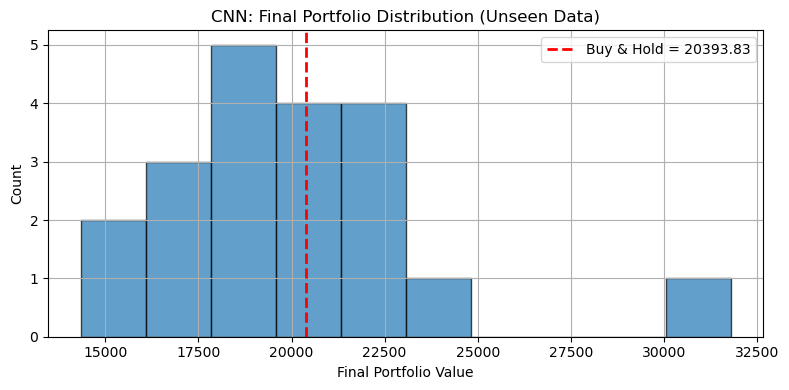

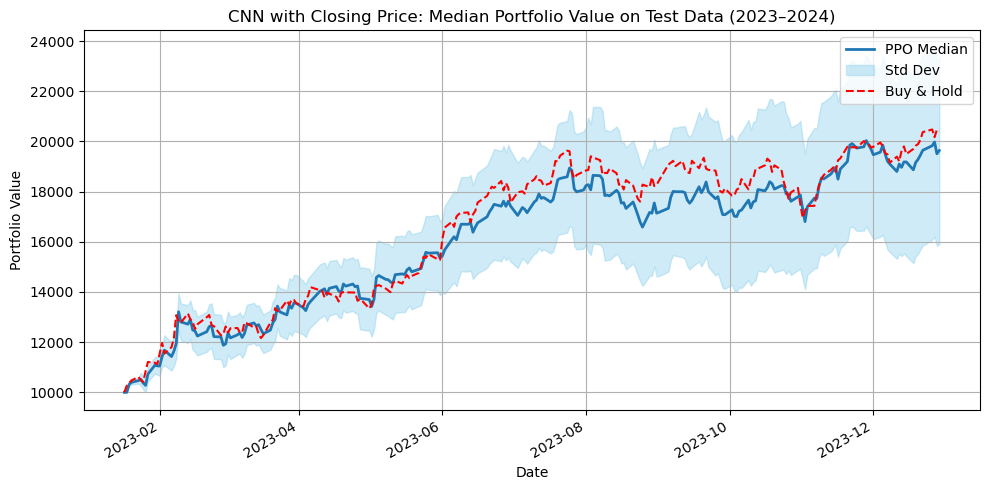

In [681]:
import yfinance as yf
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import matplotlib.dates as mdates
import os

tickers = ["AAPL", "MSFT", "GOOGL", "META", "AMZN", "TSLA", "NVDA"]
start, end = "2023-01-01", "2024-01-01"
state_dim = 5
initial_cash = 10000.0
n_runs = 20

# === Load test price data ===
raw_prices_test = {}
for t in tickers:
    df = yf.download(t, start=start, end=end)
    raw_prices_test[t] = df["Close"].values.astype(np.float32)
dates = df.index

# === Load Buy & Hold test curve (precomputed) ===
with open("buyhold_2023_2024.pkl", "rb") as f:
    bh_data = pickle.load(f)
bh_curve = bh_data["curve"]
bh_final = bh_curve[-1]
bh_dates = pd.to_datetime(bh_data["dates"])

# === Load model ===
model.load_state_dict(torch.load("model_cnn_6.pth"))
model.eval()

# === Precompute normalization ===
mean_price = {t: raw_prices_test[t].mean() for t in tickers}
std_price  = {t: raw_prices_test[t].std()  for t in tickers}

# === PPO Test Evaluation ===
final_pf = []
ppo_trajectories = []

print("Running CNN (Closing Price) on Unseen Data...\n")

with torch.no_grad():
    for run in range(n_runs):
        env = MultiStockEnvironment(raw_prices_test, window_size=state_dim)
        state_dict = env.reset()
        done = False
        trajectory = [env.initial_cash]

        while not done:
            actions = {}
            for t in tickers:
                win = state_dict[t]
                norm_p = (win - mean_price[t]) / std_price[t]
                st = torch.tensor(norm_p, dtype=torch.float32).view(1, -1)
                a_val = get_action(st, model)[0].item()
                actions[t] = a_val

            state_dict, port_val, done, _ = env.step(actions)
            trajectory.append(port_val)

        final_val = trajectory[-1]
        final_pf.append(final_val)
        ppo_trajectories.append(trajectory)
        print(f"Run {run+1:3d}/{n_runs} → Final Value: {final_val:.2f}")

# === Summary ===
mean_pf = np.mean(final_pf)
std_pf = np.std(final_pf)
min_pf = np.min(final_pf)
max_pf = np.max(final_pf)
beats = sum(p > bh_final for p in final_pf)
beat_pct = beats / n_runs * 100

agent_returns = [(pf / initial_cash - 1) * 100 for pf in final_pf]
bh_return = (bh_final / initial_cash - 1) * 100

print(f"\n=== CNN Policy on Unseen Data (2023–2024) ===")
print(f"Runs: {n_runs}")
print(f"→ Final Portfolio: mean {mean_pf:.2f} ± {std_pf:.2f}")
print(f"→ Min: {min_pf:.2f}, Max: {max_pf:.2f}")
print(f"→ Buy & Hold Final Portfolio: {bh_final:.2f}")
print(f"→ PPO beats Buy & Hold in {beats}/{n_runs} runs ({beat_pct:.1f}%)")
print(f"\n→ Avg Agent Return: {np.mean(agent_returns):.2f}% ± {np.std(agent_returns):.2f}%")
print(f"→ Buy & Hold Return: {bh_return:.2f}%")

# === Pad trajectories ===
max_len = max(len(p) for p in ppo_trajectories)
for i in range(n_runs):
    last = ppo_trajectories[i][-1]
    ppo_trajectories[i] += [last] * (max_len - len(ppo_trajectories[i]))

ppo_array = np.array(ppo_trajectories)
median_curve = np.median(ppo_array, axis=0)
std_curve    = np.std(ppo_array, axis=0)

# === Save folder ===
os.makedirs("CNN_Closing", exist_ok=True)

# === Histogram ===
plt.figure(figsize=(8, 4))
plt.hist(final_pf, bins=10, edgecolor='k', alpha=0.7)
plt.axvline(bh_final, color='r', linestyle='--', linewidth=2, label=f'Buy & Hold = {bh_final:.2f}')
plt.title("CNN: Final Portfolio Distribution (Unseen Data)")
plt.xlabel("Final Portfolio Value")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.savefig("CNN_Closing/UNSEEN_hist.png", dpi=600)
plt.show()

# === Median ± Std plot ===
plot_dates = bh_dates[state_dim - 1 : state_dim - 1 + len(median_curve)]
min_len = min(len(plot_dates), len(median_curve), len(bh_curve))
plot_dates = plot_dates[:min_len]
median_curve = median_curve[:min_len]
std_curve = std_curve[:min_len]
bh_curve = bh_curve[:min_len]

plt.figure(figsize=(10, 5))
plt.plot(plot_dates, median_curve, label='PPO Median', linewidth=2)
plt.fill_between(plot_dates, median_curve - std_curve, median_curve + std_curve,
                 color='skyblue', alpha=0.4, label='Std Dev')
plt.plot(plot_dates, bh_curve, 'r--', label='Buy & Hold')

plt.title("CNN with Closing Price: Median Portfolio Value on Test Data (2023–2024)")
plt.ylabel("Portfolio Value")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.savefig("CNN_Closing/UNSEEN_median_std1.png", dpi=600)
plt.show()


pd.DataFrame({"final_portfolio_value": final_pf}).to_csv("CNN_Closing/cnn_test_final_portfolios1.csv", index=False)
pd.DataFrame(ppo_trajectories).T.to_csv("CNN_Closing/cnn_test_all_trajectories1.csv", index=False)

#print("✓ Saved final portfolio values → CNN_Closing/cnn_test_final_portfolios.csv")
#print("✓ Saved all PPO trajectories → CNN_Closing/cnn_test_all_trajectories.csv")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/var/folders/1b/2dv3_3nx66s3980gg6hg5g1m0000gn/T/ipykernel_1522/3085362984.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This

Running CNN (Closing Price) on Unseen Data...

Run   1/200 → Final Value: 16040.36
Run   2/200 → Final Value: 21525.61
Run   3/200 → Final Value: 19221.17
Run   4/200 → Final Value: 30296.64
Run   5/200 → Final Value: 17725.26
Run   6/200 → Final Value: 23117.69
Run   7/200 → Final Value: 16732.36
Run   8/200 → Final Value: 21543.51
Run   9/200 → Final Value: 14892.36
Run  10/200 → Final Value: 19232.88
Run  11/200 → Final Value: 20036.89
Run  12/200 → Final Value: 15722.13
Run  13/200 → Final Value: 21073.32
Run  14/200 → Final Value: 15994.03
Run  15/200 → Final Value: 17165.24
Run  16/200 → Final Value: 16301.31
Run  17/200 → Final Value: 20560.74
Run  18/200 → Final Value: 19935.19
Run  19/200 → Final Value: 17899.60
Run  20/200 → Final Value: 28417.13
Run  21/200 → Final Value: 28065.87
Run  22/200 → Final Value: 24039.53
Run  23/200 → Final Value: 18536.71
Run  24/200 → Final Value: 17850.26
Run  25/200 → Final Value: 20102.03
Run  26/200 → Final Value: 17887.33
Run  27/200 → Fin

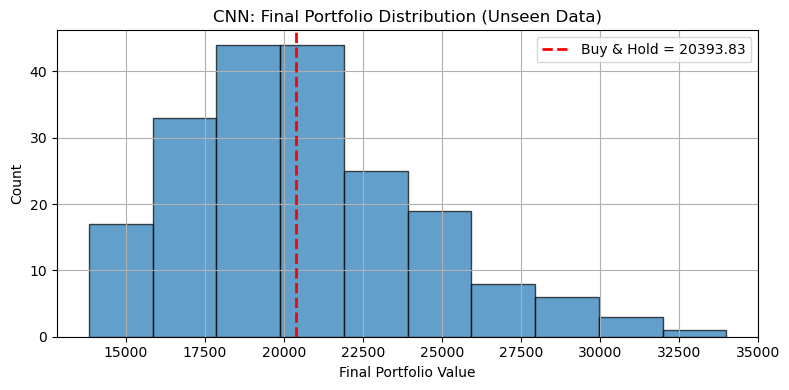

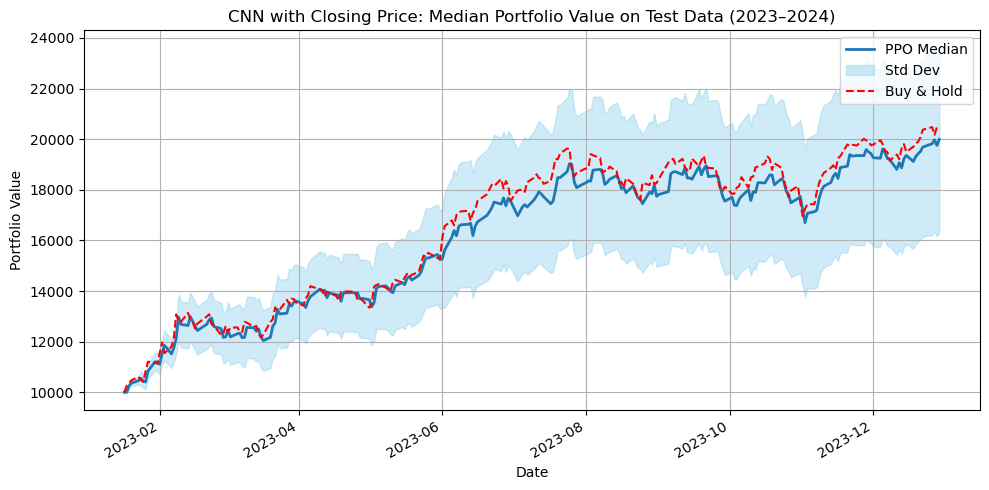

✓ Saved final portfolio values → CNN_Closing/cnn_test_final_portfolios.csv
✓ Saved all PPO trajectories → CNN_Closing/cnn_test_all_trajectories.csv


In [618]:
import yfinance as yf
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import matplotlib.dates as mdates
import os

tickers = ["AAPL", "MSFT", "GOOGL", "META", "AMZN", "TSLA", "NVDA"]
start, end = "2023-01-01", "2024-01-01"
state_dim = 5
initial_cash = 10000.0
n_runs = 20

# === Load test price data ===
raw_prices_test = {}
for t in tickers:
    df = yf.download(t, start=start, end=end)
    raw_prices_test[t] = df["Close"].values.astype(np.float32)
dates = df.index

# === Load Buy & Hold test curve (precomputed) ===
with open("buyhold_2023_2024.pkl", "rb") as f:
    bh_data = pickle.load(f)
bh_curve = bh_data["curve"]
bh_final = bh_curve[-1]
bh_dates = pd.to_datetime(bh_data["dates"])

# === Load model ===
model.load_state_dict(torch.load("model_cnn_2.pth"))
model.eval()

# === Precompute normalization ===
mean_price = {t: raw_prices_test[t].mean() for t in tickers}
std_price  = {t: raw_prices_test[t].std()  for t in tickers}

# === PPO Test Evaluation ===
final_pf = []
ppo_trajectories = []

print("Running CNN (Closing Price) on Unseen Data...\n")

with torch.no_grad():
    for run in range(n_runs):
        env = MultiStockEnvironment(raw_prices_test, window_size=state_dim)
        state_dict = env.reset()
        done = False
        trajectory = [env.initial_cash]

        while not done:
            actions = {}
            for t in tickers:
                win = state_dict[t]
                norm_p = (win - mean_price[t]) / std_price[t]
                st = torch.tensor(norm_p, dtype=torch.float32).view(1, -1)
                a_val = get_action(st, model)[0].item()
                actions[t] = a_val

            state_dict, port_val, done, _ = env.step(actions)
            trajectory.append(port_val)

        final_val = trajectory[-1]
        final_pf.append(final_val)
        ppo_trajectories.append(trajectory)
        print(f"Run {run+1:3d}/{n_runs} → Final Value: {final_val:.2f}")

# === Summary ===
mean_pf = np.mean(final_pf)
std_pf = np.std(final_pf)
min_pf = np.min(final_pf)
max_pf = np.max(final_pf)
beats = sum(p > bh_final for p in final_pf)
beat_pct = beats / n_runs * 100

agent_returns = [(pf / initial_cash - 1) * 100 for pf in final_pf]
bh_return = (bh_final / initial_cash - 1) * 100

print(f"\n=== CNN Policy on Unseen Data (2023–2024) ===")
print(f"Runs: {n_runs}")
print(f"→ Final Portfolio: mean {mean_pf:.2f} ± {std_pf:.2f}")
print(f"→ Min: {min_pf:.2f}, Max: {max_pf:.2f}")
print(f"→ Buy & Hold Final Portfolio: {bh_final:.2f}")
print(f"→ PPO beats Buy & Hold in {beats}/{n_runs} runs ({beat_pct:.1f}%)")
print(f"\n→ Avg Agent Return: {np.mean(agent_returns):.2f}% ± {np.std(agent_returns):.2f}%")
print(f"→ Buy & Hold Return: {bh_return:.2f}%")

# === Pad trajectories ===
max_len = max(len(p) for p in ppo_trajectories)
for i in range(n_runs):
    last = ppo_trajectories[i][-1]
    ppo_trajectories[i] += [last] * (max_len - len(ppo_trajectories[i]))

ppo_array = np.array(ppo_trajectories)
median_curve = np.median(ppo_array, axis=0)
std_curve    = np.std(ppo_array, axis=0)

# === Save folder ===
os.makedirs("CNN_Closing", exist_ok=True)

# === Histogram ===
plt.figure(figsize=(8, 4))
plt.hist(final_pf, bins=10, edgecolor='k', alpha=0.7)
plt.axvline(bh_final, color='r', linestyle='--', linewidth=2, label=f'Buy & Hold = {bh_final:.2f}')
plt.title("CNN: Final Portfolio Distribution (Unseen Data)")
plt.xlabel("Final Portfolio Value")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("CNN_Closing/UNSEEN_hist.png", dpi=600)
plt.show()

# === Median ± Std plot ===
plot_dates = bh_dates[state_dim - 1 : state_dim - 1 + len(median_curve)]
min_len = min(len(plot_dates), len(median_curve), len(bh_curve))
plot_dates = plot_dates[:min_len]
median_curve = median_curve[:min_len]
std_curve = std_curve[:min_len]
bh_curve = bh_curve[:min_len]

plt.figure(figsize=(10, 5))
plt.plot(plot_dates, median_curve, label='PPO Median', linewidth=2)
plt.fill_between(plot_dates, median_curve - std_curve, median_curve + std_curve,
                 color='skyblue', alpha=0.4, label='Std Dev')
plt.plot(plot_dates, bh_curve, 'r--', label='Buy & Hold')

plt.title("CNN with Closing Price: Median Portfolio Value on Test Data (2023–2024)")
plt.ylabel("Portfolio Value")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.savefig("CNN_Closing/UNSEEN_median_std.png", dpi=600)
plt.show()

# === Save CSVs ===
pd.DataFrame({"final_portfolio_value": final_pf}).to_csv("CNN_Closing/cnn_test_final_portfolios.csv", index=False)
pd.DataFrame(ppo_trajectories).T.to_csv("CNN_Closing/cnn_test_all_trajectories.csv", index=False)

print("✓ Saved final portfolio values → CNN_Closing/cnn_test_final_portfolios.csv")
print("✓ Saved all PPO trajectories → CNN_Closing/cnn_test_all_trajectories.csv")
